In [3]:
!pwd

/Users/Study


In [4]:
import pandas as pd
import glob
import numpy as np

# Helper function to check if a given coordinate is within Manhattan
def IsManhattan(point, my_dict):
    result = False
    xTest = point[0]
    yTest = point[1]
    
    # Debugging statement to show current parameters 
    # print("Testing: " + str(xTest) + ", " + str(yTest))
    for key, values in my_dict.items():
        # Point 1 = (x1, y1)
        x1 = values[0][0] 
        y1 = values[0][1]
        # Point 2 = (x4, y4)
        x4 = values[1][0] 
        y4 = values[1][1]
        
        # print(str(x1) + "<=" + str(xTest) + "<=" + str(x4))
        # If the point is within that rectangle area space
        if (x1 <= xTest <= x4) and (y1 <= yTest <= y4):
            # print("You are in: " + key)
            result = True
            return result      
    return result

# Creating a list of all CSV file in the path directory
path = r'/Users/Study'
all_files = glob.glob(path + "/*.csv")

# tempCitibike list that store the file data frame
tempCitibike = []
# Track how many records total
totalRecordCount = 0

# Loop and append the dataframes into tempCitibke List
for filename in all_files:
    # Filename is the path/file.ext
    print(filename)
    df = pd.read_csv(filename) 
    
    # Output the (rowCount, columnCount) to terminal
    print("Size: " + str(df.shape))
    
    totalRecordCount += df.shape[0]
    tempCitibike.append(df)

# Combine the tempCitibike dfs together
citibike = pd.concat(tempCitibike)
print("\nThere are " + "{:,}".format(totalRecordCount) + " number of records.")
print("Before dropping NaN: " + str(citibike.shape))

# Drop rows with any (missing) variables
citibike.dropna(inplace = True)
print("After dropping NaN: " + str(citibike.shape))

manhattan_box = {
    "Lower_Manhattan_1":([40.702240, -74.019057], [40.709680, -73.994678]), 
    "Lower_Manhattan_2":([40.709675, -74.019498], [40.721143, -73.972980]), 
    "Lower_Manhattan_3":([40.721143, -73.972980], [40.739456, -74.012773]),
    "Midtown_1":([40.739456, -74.012773], [40.749486, -73.963889]), 
    "Midtown_2":([40.749486, -73.963889], [40.773278, -73.999485]), 
    "Midtown_3":([40.768591, -74.001211], [40.784832, -73.939566]), 
    "Midtown_4":([40.731666, -74.017891], [40.777325, -73.957480]),
    "Uptown_1":([40.786963, -73.984324], [40.799808, -73.926743]), 
    "Uptown_2":([40.807760, -73.972507], [40.844010, -73.922678]), 
    "Uptown_3":([40.833729, -73.952387], [40.842837, -73.919586]), 
}

# Getting the start station subset (5M rows and 4 columns)
startStation = citibike[['start station id', 
                         'start station name', 
                         'start station latitude', 
                         'start station longitude']]

# Rename the coloumns without start prefix and replace spaces
startStation.rename(columns={
    "start station id":"station_id", 
    "start station name":"station_name",
    "start station latitude":"station_latitude",
    "start station longitude":"station_longitude"
}, inplace=True)

# Getting the start station subset (5M rows and 4 columns)
endStation = citibike[[
    'end station id', 
    'end station name', 
    'end station latitude', 
    'end station longitude'
]]

# Rename the coloumns without start prefix and replace spaces
endStation.rename(columns={
    "end station id":"station_id", 
    "end station name":"station_name",
    "end station latitude":"station_latitude",
    "end station longitude":"station_longitude"
}, inplace=True)

# Adding the start and end list into one
station_df = startStation.append(endStation)

# Drop duplicates, keeping only the first obs
station_df.drop_duplicates(keep='first', inplace=True)

# Create a new column 
station_df['inManhattan'] = ''

# Looping 1 row at time for the station lookup table
# Using the helper function to determine if it is within Manhattan
# or outside of it.
for index, row in station_df.iterrows():
    point = (row['station_latitude'], row['station_longitude'])
    result = IsManhattan(point, manhattan_box)
    station_df.at[index, 'inManhattan'] = result
    
# Add two new columns in the citibke main dataset
station_df.drop_duplicates(subset='station_id', keep='first', inplace=True)


/Users/Study/201902-citibike-tripdata.csv
Size: (943744, 15)
/Users/Study/201904-citibike-tripdata.csv
Size: (1766094, 15)
/Users/Study/201903-citibike-tripdata.csv
Size: (1327960, 15)
/Users/Study/201901-citibike-tripdata.csv
Size: (967287, 15)

There are 5,005,085 number of records.
Before dropping NaN: (5005085, 15)
After dropping NaN: (5005048, 15)


/Users/Study/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [5]:
station_df_index = station_df[['station_id', 'inManhattan']]
station_df_index.set_index('station_id', inplace=True)

In [9]:
citibike_test = citibike.copy()
citibike_test.set_index('start station id', inplace=True)

# Inner join to get the start station flags
citibike_test = citibike_test.join(station_df_index)

# Rename that new column as from_Flag
citibike_test.rename(columns={"inManhattan":"from_Flag"}, inplace=True)

# Set index to end station id
citibike_test.set_index('end station id', inplace=True)

In [17]:
# Inner join to get the end station flags
citibike_test = citibike_test.join(station_df_index)

# Rename that new column as end_Flag
citibike_test.rename(columns={"inManhattan":"end_Flag"}, inplace=True)

In [59]:
citibike_test5 = citibike_test.sample(n=200000) # 100k sample out of 50M

In [54]:
# citibike_test = citibike_test.sample(frac=0.5) # 100k sample out of 50M

import time
start_time = time.time()

for index, row in citibike_test5.iterrows():
    # Getting the from/end Manhattan flag
    # start_In_City = row['from_Flag']
    # end_In_City  = row['end_Flag']
    
    result = 'NA' # Blank value

    # Manhattan to Manhattan
    if (row['from_Flag'] == True and row['end_Flag'] == True):
        result = 'MM' 
    # Outter to Manhattan
    elif (row['from_Flag'] == False and row['end_Flag'] == True):
        result = 'OM' 
    # Manhattan to Outter
    elif (row['from_Flag'] == True and row['end_Flag'] == False):
        result = 'MO' 
    # Outter to Outter
    else:
        result = 'OO' 
    citibike_test5.at[index, 'trip_indicator'] = result
    
    myHour = row['starttime'][11:13] # The hour starting position string
    if myHour < '13':
        citibike_test5.at[index, 'hour'] = str(myHour) + 'AM'
    else:
        citibike_test5.at[index, 'hour'] = str(myHour) + 'PM'
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 197.0851390361786 seconds ---


In [45]:
CityMap = {(True, True):"MM",
           (False, False): "OO",
           (False, True): "OM",
           (True, False): "MO"}

In [ ]:
# citibike_test = citibike_test.sample(frac=0.5) # 100k sample out of 50M

import time
start_time = time.time()

for index, row in citibike_test5.iterrows():    
    flagPair = (row['from_Flag'], row['end_Flag'])
    citibike_test5.at[index, 'trip_indicator'] = CityMap[flagPair]
    
    myHour = row['starttime'][11:13] # The hour starting position string
    if myHour < '13':
        citibike_test5.at[index, 'hour'] = str(myHour) + 'AM'
    else:
        citibike_test5.at[index, 'hour'] = str(myHour) + 'PM'
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 261.13526701927185 seconds ---


In [201]:
# Subset the citibike_test with time_df
time_df = citibike_test[['trip_indicator', 'starttime']]

In [203]:
# Group by and count with dataframe method
test_dataset = time_df.groupby(['hour', 'trip_indicator']).count()

In [204]:
# Unstack the groupby object
test_unstack = test_dataset.unstack()

In [205]:
# Divide by 4 months (120) days to get daily average
test_unstack2 = test_unstack.div(120)

In [208]:
# Testing and showing what it looks like
# type(test_unstack)
# test_unstack2

starttime                                    
trip_indicator           MM          MO          OM          OO
hour                                                           
00AM             131.991667   36.175000   35.016667   94.800000
01AM              71.700000   20.308333   20.450000   53.958333
02AM              43.208333   11.941667   11.766667   31.083333
03AM              29.350000    7.366667    8.258333   19.183333
04AM              47.208333    8.133333    8.025000   18.241667
05AM             172.833333   21.850000   29.791667   58.266667
06AM             576.258333   65.275000   88.991667  189.616667
07AM            1157.700000  141.016667  231.383333  430.566667
08AM            2019.458333  270.041667  483.291667  742.508333
09AM            1558.425000  249.325000  355.916667  629.366667
10AM            1036.300000  191.725000  222.033333  458.666667
11AM            1055.475000  201.441667  212.500000  478.041667
12AM            1260.583333  230.716667  240.291667  546.641667
13PM            1331.816667  257.166667  257.083333  569.650000
14PM            1381.850000  261.783333  265.175000  596.358333
15PM            1459.991667  283.075000  277.233333  627.033333
16PM            1725.600000  340.100000  297.666667  660.116667
17PM            2434.491667  524.933333  374.616667  840.516667
18PM            2074.750000  520.808333  362.575000  906.116667
19PM            1289.591667  330.241667  253.858333  682.375000
20PM             823.766667  213.491667  173.850000  461.958333
21PM             555.191667  140.283333  126.791667  322.741667
22PM             396.650000  105.891667   97.550000  249.758333
23PM             245.608333   64.650000   63.583333  165.925000

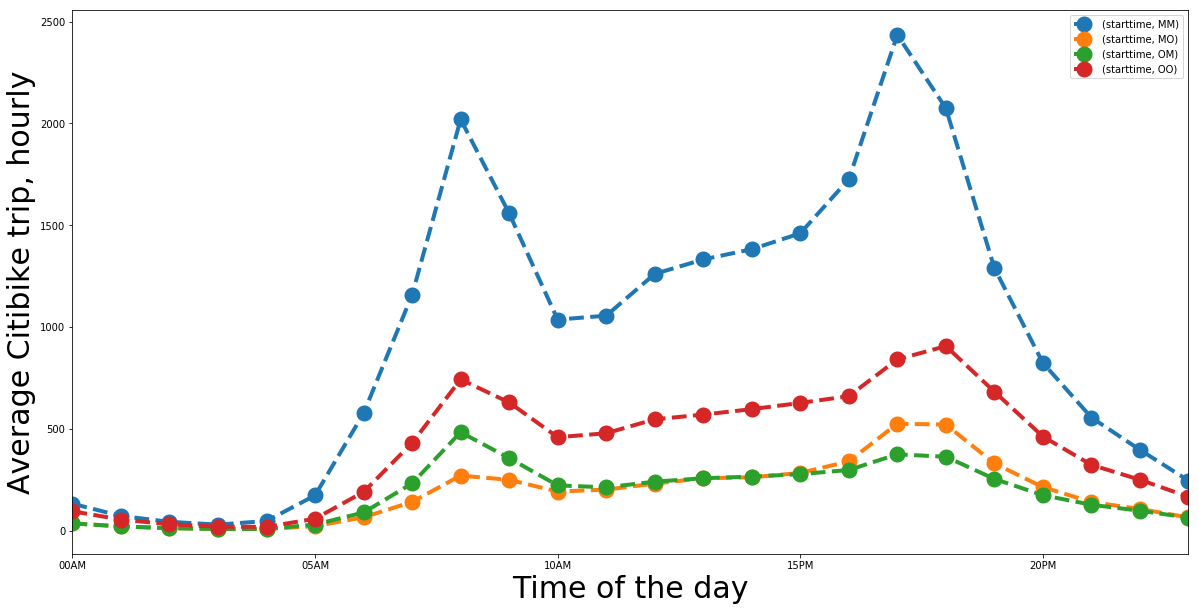

In [232]:
import matplotlib.pyplot as plt
    
test_unstack2.plot(figsize=(20,10), 
                  linewidth=4.0, 
                  markeredgewidth=10.0,
                  linestyle='--', marker='o')
plt.ylabel('Average Citibike trip, hourly', fontsize=30)
plt.xlabel('Time of the day', fontsize=30)
plt.legend()
# plt.text(1966, -8, "Data source: nces.ed.gov/programs/digest/2013menu_tables.asp", fontsize=10) 


plt.draw()
plt.savefig('foo.png')